# Vehicle Classification

## Evaluate your model


In [1]:
# Importing the necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import utils
from sklearn.metrics import accuracy_score, classification_report
from mobilenet_model import mobilenetv3_model



## Experiment settings

Set here the two variables in the following way:

- **CONFIG_YML:** assign the path to the config.yml file used for the experiment you want to evaluate
- **WEIGHTS:** assign the path to the model weights (.h5 file) you want to evaluate


In [32]:
# Getting the yaml and weights files to be used
CONFIG_YML = "/data_volume/alan/ay22-01-final-project-5/mobilenet_weights/w_002/config_mobilenet7.yml"
WEIGHTS = "/data_volume/alan/ay22-01-final-project-5/alan/ay22-01-final-project-5/mobilenet_weights/w_007/model.77-0.1488.h5"

In [33]:
# Showing the yaml configuration file
config = utils.load_config(CONFIG_YML)
config

{'seed': 123,
 'data': {'directory': '/data_volume/dataset/mobilenet_training_dataset_no_trash/train',
  'labels': 'inferred',
  'label_mode': 'categorical',
  'validation_split': 0.2,
  'image_size': [224, 224],
  'batch_size': 8},
 'model': {'weights': 'imagenet',
  'input_shape': [224, 224, 3],
  'classes': 2,
  'dropout_rate': 0.6},
 'compile': {'optimizer': {'adam': {'learning_rate': 1e-06}},
  'loss': 'categorical_crossentropy',
  'metrics': ['accuracy']},
 'fit': {'epochs': 200,
  'callbacks': {'model_checkpoint': {'filepath': '/home/app/src/alan/ay22-01-final-project-5/mobilenet_weights/w_007/model.{epoch:02d}-{val_loss:.4f}.h5',
    'save_best_only': True},
   'tensor_board': {'log_dir': '/home/app/src/alan/ay22-01-final-project-5/mobilenet_weights/w_007/logs'}}}}

In [36]:
# Check if there are any mistakes with the information

MODEL_CLASSES = utils.get_class_names(config)

if len(MODEL_CLASSES) != config['model']['classes']:
    raise ValueError(
        "Number of classes doesn't match between your model "
        "and your data!"
    )

_dirname, _ = os.path.split(config['data']['directory'])
TEST_FOLDER = os.path.join(_dirname, 'test')

if not os.path.exists(TEST_FOLDER):
    raise ValueError("'test' folder not found!")
    
if len(os.listdir(TEST_FOLDER)) != config['model']['classes']:
    raise ValueError(
        "Number of classes doesn't match between your model "
        "and your testing dataset!"
    )
    
if set(os.listdir(TEST_FOLDER)) != set(MODEL_CLASSES):
    raise ValueError(
        "The name of the subfolders inside your test set "
        "doesn't match with the model classes!"
    )

## Load your model

Use `mobilenetv3_model.create_model()` and remember to properly setup the model weights!

Assign the model to the variable `cnn_model`.


In [37]:
# Loading weights of the model and printing the summary
cnn_model = mobilenetv3_model.create_model(weights=WEIGHTS)

print(cnn_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 2)                 1922      
                                                                 
Total params: 2,998,274
Trainable params: 2,973,874
Non-trainable params: 24,400
_________________________________________________________________
None


## Get predictions from testing dataset

In [38]:
# Using the loaded model and the function utils.predict_from_folder() to get 
# the model predictions and the corresponding true labels so we can measure
# the accuracy

predictions, labels, pred_file_paths = utils.predict_from_folder(
    folder=TEST_FOLDER, 
    model=cnn_model, 
    input_size=config["data"]["image_size"], 
    class_names=MODEL_CLASSES,
)

if len(predictions) != len(labels):
    raise ValueError(
        "The lenght of predictions and labels lists doesn't match!"
    )

if not isinstance(predictions[0], str):
    raise ValueError(
        "Model predictions should be represented as string. E.g: 'Acura RL Sedan 2012'"
    )

if not isinstance(labels[0], str):
    raise ValueError(
        "Ground true labels should be represented as string. E.g: 'Acura RL Sedan 2012'"
    )


In [39]:
# Printing the classification report

print(classification_report(y_true=labels, y_pred=predictions))


              precision    recall  f1-score   support

         ext       0.99      0.95      0.97       120
         int       0.95      0.99      0.97       120

    accuracy                           0.97       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.97      0.97      0.97       240



In [40]:
# Calculating the model's accuracy

acc = accuracy_score(y_true=labels, y_pred=predictions)

print(f"Your model accuracy is {acc:.4f}!")

if acc < .3:
    raise ValueError("Your model accuracy is too low :(\nYou can do it better! :)")


Your model accuracy is 0.9708!


In [43]:
# Creating a mask that will be used to find in which files there was a mistake
pred_mask = [prediction == label for prediction, label in zip(predictions,labels)]
np.invert(pred_mask)

array([False, False,  True, False, False, False, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,

In [44]:
# Getting the indices of the mismatched images
preds = np.array(pred_mask)
mismatch_indices = np.argwhere(np.invert(preds))
mismatch_indices

array([[  2],
       [  9],
       [ 11],
       [ 66],
       [ 77],
       [ 95],
       [123]])

In [45]:
# Getting the predicted file paths
pred_file_paths = np.array(pred_file_paths)
len(pred_file_paths)

240

In [46]:
# Getting the mismatch file paths
mismatch_pred_file_paths = pred_file_paths[mismatch_indices.ravel()]
mismatch_pred_file_paths

array(['/data_volume/dataset/mobilenet_training_dataset_no_trash/test/ext/3454.jpg',
       '/data_volume/dataset/mobilenet_training_dataset_no_trash/test/ext/3499.jpg',
       '/data_volume/dataset/mobilenet_training_dataset_no_trash/test/ext/4800.jpg',
       '/data_volume/dataset/mobilenet_training_dataset_no_trash/test/ext/2091.jpg',
       '/data_volume/dataset/mobilenet_training_dataset_no_trash/test/ext/4797.jpg',
       '/data_volume/dataset/mobilenet_training_dataset_no_trash/test/ext/3126.jpg',
       '/data_volume/dataset/mobilenet_training_dataset_no_trash/test/int/1199.jpg'],
      dtype='<U74')

2
/data_volume/dataset/mobilenet_training_dataset_no_trash/test/ext/3454.jpg int ext


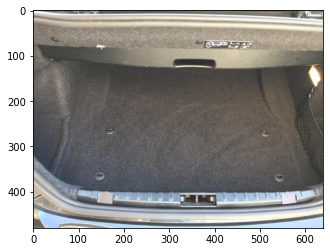

9
/data_volume/dataset/mobilenet_training_dataset_no_trash/test/ext/3499.jpg int ext


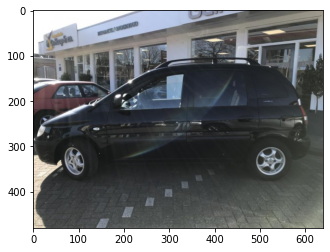

11
/data_volume/dataset/mobilenet_training_dataset_no_trash/test/ext/4800.jpg int ext


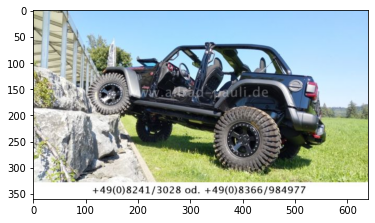

66
/data_volume/dataset/mobilenet_training_dataset_no_trash/test/ext/2091.jpg int ext


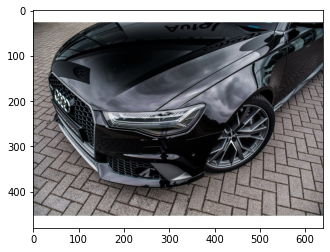

77
/data_volume/dataset/mobilenet_training_dataset_no_trash/test/ext/4797.jpg int ext


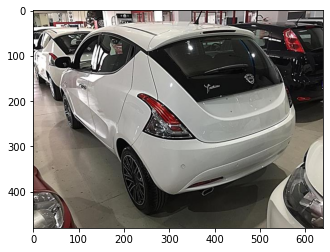

95
/data_volume/dataset/mobilenet_training_dataset_no_trash/test/ext/3126.jpg int ext


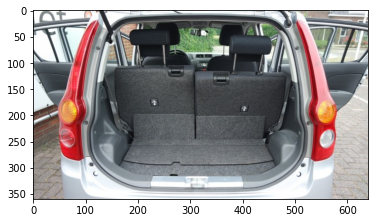

123
/data_volume/dataset/mobilenet_training_dataset_no_trash/test/int/1199.jpg ext int


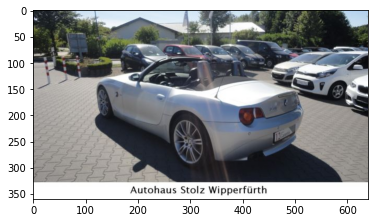

In [48]:
# Load mismatched images and showing the paths, what it was predicted and what it should be 
for index in mismatch_indices.ravel():
    print(index)
    file_path = pred_file_paths[index]
    pred_class = predictions[index]
    real_class = labels[index]
    print(file_path, pred_class, real_class)
    img = cv2.imread(file_path)
    # Convert from RGB to RGB first
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()